Smoothed NDVI

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from p_drought_indices.functions.ndvi_functions import get_irradiances, compute_ndvi_corr

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

ndvi_dir = config_file['NDVI']['ndvi_prep']
    
new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = xr.open_dataset(list_files_2[1000])

msg_type = ds.attrs['EPCT_product_name'][:4]

girradiance_vis6, irradiance_vis8 = get_irradiances(msg_type)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
ds = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))
ds_ndvi = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_prep'], 'final_ndvi.nc'))
ds_smoot = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'vci_1D.nc'))

In [ ]:
import pandas as pd 
from datetime import timedelta

from p_drought_indices.analysis.visualizations.viz_series import plot_ndvi_days

plot_ndvi_days(ds_smoot,
               start_day="2010-01-01",
                num_timesteps=15)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing, get_lat_lon_window
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import pickle

CONFIG_PATH= "../config.yaml"

time_end = "2019-12-31"
time_start = "2005-01-01"


def spi_ndvi_convlstm():
    config_file = load_config(CONFIG_PATH=CONFIG_PATH)

    # Open the NetCDF file with xarray
    dataset = prepare(xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))).sel(time=slice(time_start,time_end))

    prod = "ERA5"
    late = 90

    path = config_file['SPI']['ERA5']['path']
    file = "era5_land_merged.nc" #f"ERA5_spi_gamma_{late}.nc"
    precp_ds = xr.open_dataset(os.path.join(path, file))
    var_target = "spi_gamma_{}".format(late)
    print(f"The {prod} raster has spatial dimensions:", precp_ds.rio.resolution())

    #### training parameters
    train_split = 0.8
    batch_size=4
    dim=64
    preprocess_type="None"

    ### Load dataset
    file_path = os.path.join(config_file["DEFAULT"]["data"],'preprocessed_data.pkl')
    if os.path.exists(file_path):
        print("The file exists. Proceeding with the analysis")
        with open(file_path, 'rb') as file:
            train_data, test_data, train_label, test_label = pickle.load(file)
    else:
        print("The file does not exist. Proceeding with preprocessing")
        idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
        sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
            .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
        ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})

        

        train_data, test_data, train_label, test_label = CNN_preprocessing(ds, sub_precp, var_origin="ndvi", var_target=var_target, preprocess_type=preprocess_type,  split=train_split)
        # Save the image data using pickle
        with open(file_path, 'wb') as file:
            pickle.dump((train_data, test_data, train_label, test_label), file)
        print("Data written to pickle file")

    # create a CustomDataset object using the reshaped input data
    train_dataset = CustomDataset(train_data, train_label)
    test_dataset = CustomDataset(test_data, test_label)
    
    # create a DataLoader object that uses the dataset
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    ### check shape of data
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    
    
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())


    #### Start training

    from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
    from torch.nn import MSELoss
    import matplotlib.pyplot as plt
    from p_drought_indices.analysis.DeepLearning.ConvLSTM import ConvLSTM, train_loop, valid_loop, build_logging
    import numpy as np
    
    name = '3x3_16_3x3_32_3x3_64'
    
    logger = build_logging(config)
    model = ConvLSTM(config).to(config.device)
    #criterion = CrossEntropyLoss().to(config.device)
    #criterion = torch.nn.MSELoss().to(config.device)
    criterion = MSELoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_records, valid_records, test_records = [], [], []
    for epoch in range(config.epochs):
        epoch_records = train_loop(config, logger, epoch, model, train_dataloader, criterion, optimizer)
        train_records.append(np.mean(epoch_records['loss']))
        epoch_records = valid_loop(config, logger, epoch, model, test_dataloader, criterion)
        valid_records.append(np.mean(epoch_records['loss']))
        plt.plot(range(epoch + 1), train_records, label='train')
        plt.plot(range(epoch + 1), valid_records, label='valid')
        plt.legend()
        plt.savefig(os.path.join(config.output_dir, '{m}_{n}.png'.format(n=name, m=preprocess_type)))
        plt.close()
    

In [ ]:
from p_drought_indices.functions.function_clns import load_config
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_veg_event
import os
import xarray as xr
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)

path = config["PRECIP"]["ERA5_land"]["path"]
output_dir = os.path.join(path,  "graph_net/predicted_data")

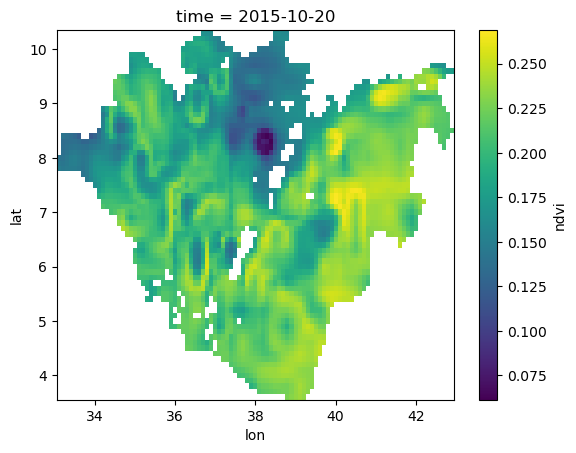

In [ ]:
ds = xr.open_dataset(os.path.join(output_dir, "predicted_ndvi_1.nc"))
ds.isel(time=0)["ndvi"].plot()

days are 366
Calculating the full year for boxplot
The days are 366
days are 365
For year 2017 obtaining only months 1 to 5 for boxplot


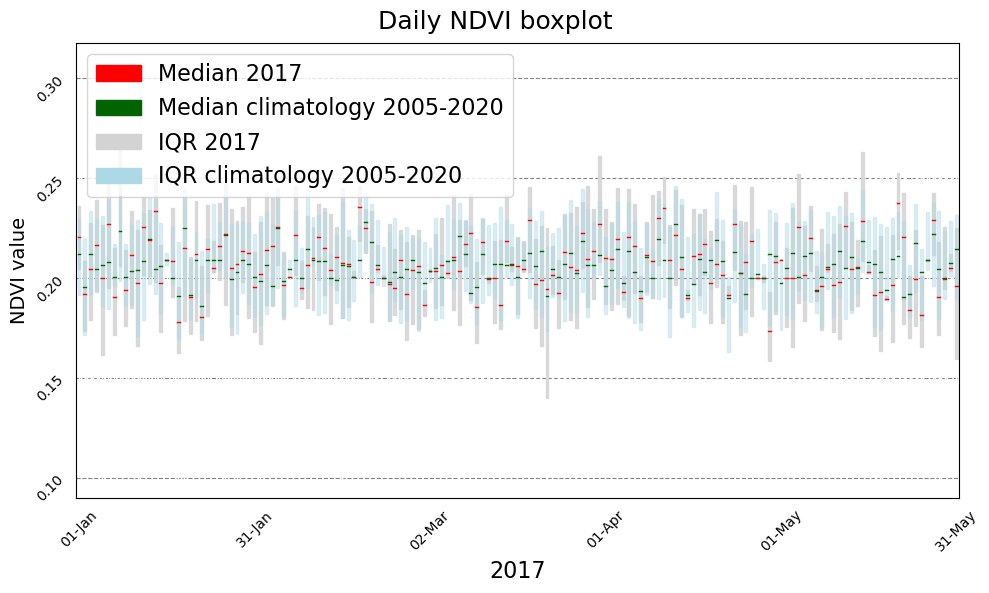

In [84]:
months = [i for i in np.arange(1,6)]
plot_veg_event(ds,year=2017, months=months)

In [2]:
from analysis.deep_learning.GWNET.pipeline_gwnet import data_preparation, check_xarray_dataset
import os
from utils.function_clns import load_config, interpolate_prepare
import torch
from analysis.deep_learning.GWNET.pipeline_gwnet import data_preparation
import os
from torch.utils.data import DataLoader
from utils.function_clns import load_config

product = "ERA5"
CONFIG_PATH = "../config.yaml"
config_file = load_config(CONFIG_PATH)


class Args:
    def __init__(self):
        self.device = 'cuda'
        self.adjtype = 'doubletransition'
        self.gcn_bool = False
        self.aptonly = False
        self.addaptadj = False
        self.randomadj = False
        self.nhid = 32
        self.in_dim = 1
        self.batch_size = config_file["CONVLSTM"]["batch_size"]
        self.learning_rate = 0.001
        self.dropout = 0.3
        self.weight_decay = 0.0001
        self.print_every = 50
        self.expid = 1
        self.latency = 90
        self.spi = False
        self.precp_product = product
        self.forecast = 12
        self.seq_length = 12
        self.country = ["Kenya", "Ethiopia", "Somalia"]
        self.region = None
        self.dim = config_file["CONVLSTM"]["pixels"]
        self.convlstm = True
        self.product = product

# Create an instance of the Args class
args = Args()
sub_precp, ds = data_preparation(args, CONFIG_PATH, precp_dataset=args.precp_product, ndvi_dataset="ndvi_smoothed_w2s.nc")
data, target = interpolate_prepare(args, sub_precp, ds)

2023-11-02 at 14:22:28 | INFO ℹ️ | Starting NDVI prediction with product ERA5 with 12 days of features...
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/s

Selecting data for ConvLSTM
lat-axis values: [14.75 14.5  14.25 14.   13.75 13.5  13.25 13.   12.75 12.5  12.25 12.
 11.75 11.5  11.25 11.   10.75 10.5  10.25 10.    9.75  9.5   9.25  9.
  8.75  8.5   8.25  8.    7.75  7.5   7.25  7.    6.75  6.5   6.25  6.
  5.75  5.5   5.25  5.    4.75  4.5   4.25  4.    3.75  3.5   3.25  3.
  2.75  2.5   2.25  2.    1.75  1.5   1.25  1.    0.75  0.5   0.25  0.
 -0.25 -0.5  -0.75 -1.  ]
lon-axis values: [33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75 36.
 36.25 36.5  36.75 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75 39.
 39.25 39.5  39.75 40.   40.25 40.5  40.75 41.   41.25 41.5  41.75 42.
 42.25 42.5  42.75 43.   43.25 43.5  43.75 44.   44.25 44.5  44.75 45.
 45.25 45.5  45.75 46.   46.25 46.5  46.75 47.   47.25 47.5  47.75 48.
 48.25 48.5  48.75 49.  ]
Dimensions: ('time', 'lat', 'lon')
Size: 22437888
Number of Dimensions: 3
Shape: (5478, 64, 64)
Coordinates: Coordinates:
  * time         (time) datetime64[ns] 2005-01-01 2005

In [10]:
from typing import Union
import geopandas as gpd
import numpy as np


def subsetting_plot(CONFIG_PATH:str, original_matrix:np.array, 
                        countries:Union[list, None] = ['Ethiopia','Kenya', 'Somalia'], 
                        regions: Union[list, None] = None):
    
    config = load_config(CONFIG_PATH)
    if regions is None and countries is None:
        raise ValueError("You must specify either a list of countries or regions")
    if regions is not None and countries is not None:
        raise ValueError("You must specify either country or regions list, not both")
    if countries is not None:
        shapefile_path = config['SHAPE']['africa']
        column = "ADM0_NAME"
        location =countries
    else:
        shapefile_path = config['SHAPE']['ethiopia']
        column = "REGIONNAME"
        location=regions

    gdf = gpd.read_file(shapefile_path)
    subset = gdf[gdf[column].isin(location)]

    bbox = subset.total_bounds

    # Define the cropping coordinates
    minx, miny, maxx, maxy = bbox

    # Determine the row and column indices corresponding to the bounding box
    # Adjust these indices as needed depending on your data format and coordinate system
    min_row, min_col = int(miny), int(minx)
    max_row, max_col = int(maxy), int(maxx)

    # Crop the original matrix to the bounding box
    return original_matrix[min_row:max_row, min_col:max_col]

In [2]:
class Args:
    def __init__(self):
        self.device = 'cuda'
        self.adjtype = 'doubletransition'
        self.gcn_bool = False
        self.aptonly = False
        self.addaptadj = False
        self.randomadj = False
        self.nhid = 32
        self.in_dim = 1
        self.batch_size = config_file["GWNET"]["batch_size"]
        self.learning_rate = 0.001
        self.dropout = 0.3
        self.weight_decay = 0.0001
        self.print_every = 50
        self.expid = 1
        self.latency = 90
        self.spi = False
        self.precp_product = product
        self.forecast = 12
        self.seq_length = 12
        self.country = ["Kenya", "Ethiopia", "Somalia"]
        self.region = None
        self.dim = config_file["GWNET"]["pixels"]
        self.convlstm = False

# Create an instance of the Args class
args = Args()

from analysis.deep_learning.GWNET.pipeline_gwnet import load_adj, MetricsRecorder, trainer,get_dataloader, data_preparation
from analysis.deep_learning.GWNET.predictions_gwnet import get_predicted_dataset
path = config_file["PRECIP"]["ERA5_land"]["path"]
args.output_dir = os.path.join(path,  "graph_net")
checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
model_path = [os.path.join(checkp_path, f) for f in os.listdir(checkp_path) if "best" in f][0]

sub_precp, ds =  data_preparation(args, CONFIG_PATH, precp_dataset=args.precp_product)
dataloader, num_nodes, x_df = get_dataloader(args, CONFIG_PATH, sub_precp, ds, check_matrix=True)

In [18]:
def test(model, loss, test_loader, args):
    """
    Test logic for the GWN model. Makes predictions on the input supplied, calculates loss(MSE) without updating weights.
    Parameters:
        test_loader - Instance of DataLoader which performs preprocessing operations and an iterator to iterate through the data
        args - Parser of parameter arguments
    Returns:
        test_loss/trainLoader.num_batch - returns the validation loss(MSE) across the batches fed into it by the DataLoader
        predictions - returns a list of the predictions made by the GWN model on the test set
        targets - returns a list of the test inputs fed into the GWN model
    """
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        test_loss = 0
        for iter, (x, y) in enumerate(test_loader.get_iterator()):
            x = torch.Tensor(x).to(args.device)
            x = x.transpose(1, 3)
            y = torch.Tensor(y).to(args.device)
            y = y.transpose(1, 3)
            input = torch.nn.functional.pad(x, (1, 0, 0, 0))
            output = model(input)
            output = output.transpose(1, 3)
            real = torch.unsqueeze(y[:, 0, :, :], dim=1)
            loss = loss(output, real)
            test_loss += loss
            predictions.append(output.cpu().detach().numpy())
            targets.append(real.cpu().detach().numpy())
        return (test_loss / test_loader.num_batch).item(), predictions, targets

In [ ]:
dates = x_df.index
cols = x_df.columns
sub_cols = [ (i[1], i[2]) for i in cols]
epochs = config_file["GWNET"]["epochs"]
dim = args.dim

device = torch.device(args.device)
adj_path = os.path.join(os.path.join(args.output_dir,  "adjacency_matrix"), f"{args.precp_product}_{args.dim}_adj_dist.pkl")
adj_mx = load_adj(adj_path,  args.adjtype)
scaler = dataloader['scaler']
supports = [torch.tensor(i).to(device) for i in adj_mx]
metrics_recorder = MetricsRecorder()
if args.spi==True:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.precp_product}_SPI_{args.latency}")
else:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]
if args.aptonly:
    supports = None
engine = trainer(scaler, args.in_dim, args.seq_length, num_nodes, args.nhid, args.dropout,
                     args.learning_rate, args.weight_decay, device, supports, args.gcn_bool, args.addaptadj,
                     adjinit)
model = engine.model.load_state_dict(torch.load(model_path))
outputs = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]
print("realy dims is: {}", realy.shape)

In [3]:
import xarray as xr
import os
from utils.function_clns import load_config, subsetting_pipeline
import numpy as np
import matplotlib.pyplot as plt

from utils.ndvi_functions import ndvi_colormap
cmap_ndvi, norm =ndvi_colormap()


CONFIG_PATH = "../config.yaml"
config_file = load_config(CONFIG_PATH)

path = os.path.join(config_file["DEFAULT"]["output"],"predicted_ndvi_val.nc")

ds_pred = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(path))["ndvi"]
split = ds_pred.sizes["time"]
ds_sub = ds.sel(time=slice(ds_pred["time"].min(), ds_pred["time"].max()))

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


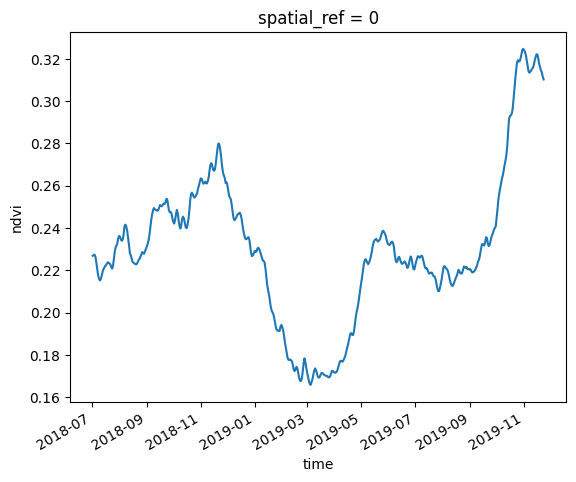

In [4]:
ds_sub.mean(["lat","lon"]).plot()

In [ ]:
ds_pred.mean(["lat","lon"]).plot()

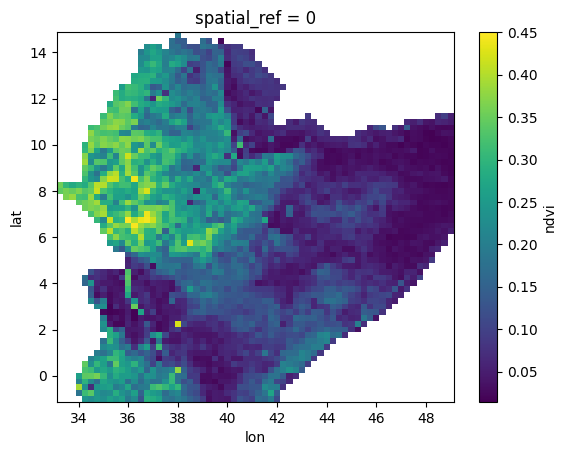

In [62]:
import xskillscore as xs
from xskillscore import Contingency

xs.rmse(ds_sub, ds_pred, dim="time").plot()

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


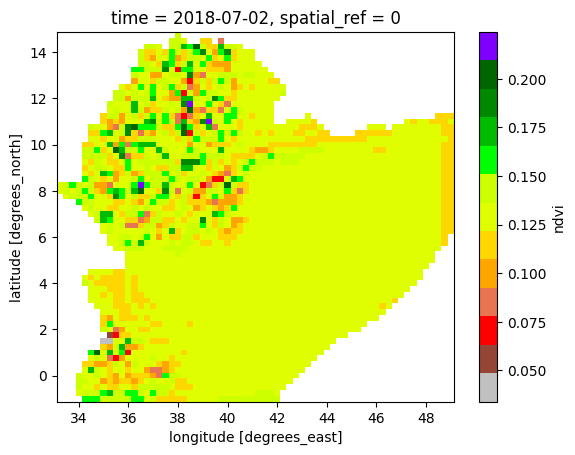

In [2]:
ds["ndvi"].isel(time=0).plot(cmap= cmap_ndvi)

In [4]:
import torch

x = torch.randn(32, 30, 18, 64, 64)
y = torch.randn(32, 16, 64, 64)

combined = torch.cat([x[:,0], y], dim=1)

In [7]:
x[:,0].shape

torch.Size([32, 18, 64, 64])

In [8]:
y.shape

torch.Size([32, 16, 64, 64])

In [5]:
combined.shape

torch.Size([32, 34, 64, 64])

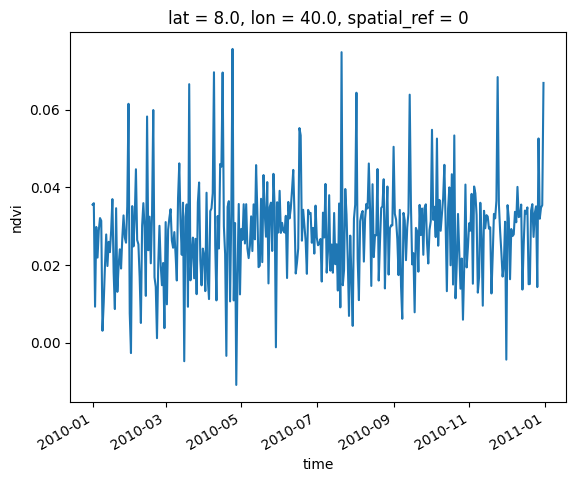

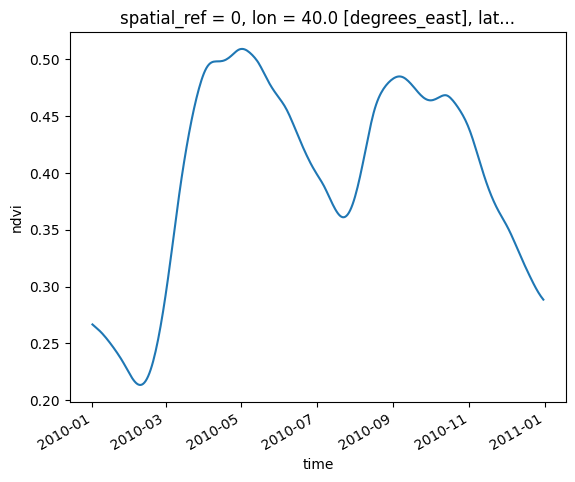

In [6]:
year = 2010
lat = 8
lon = 40

ds.sel(time=ds.time.dt.year == year).sel(lat = lat, lon = lon)["ndvi"].plot()
plt.show()

ds_ndvi.sel(time=ds_ndvi.time.dt.year == year).sel(lat = lat, lon = lon).plot()
plt.show()

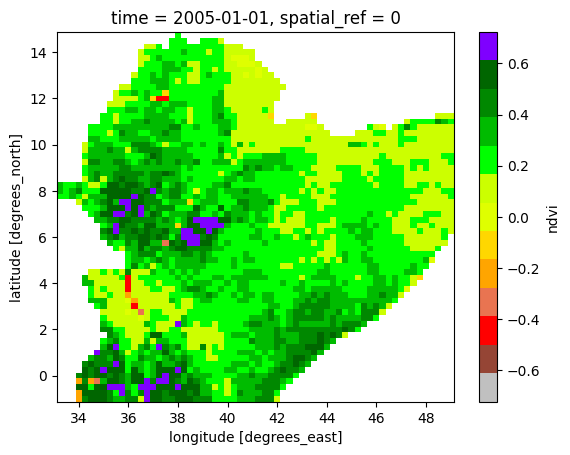

In [7]:
ds_ndvi.isel(time=0).plot(cmap= cmap_ndvi)

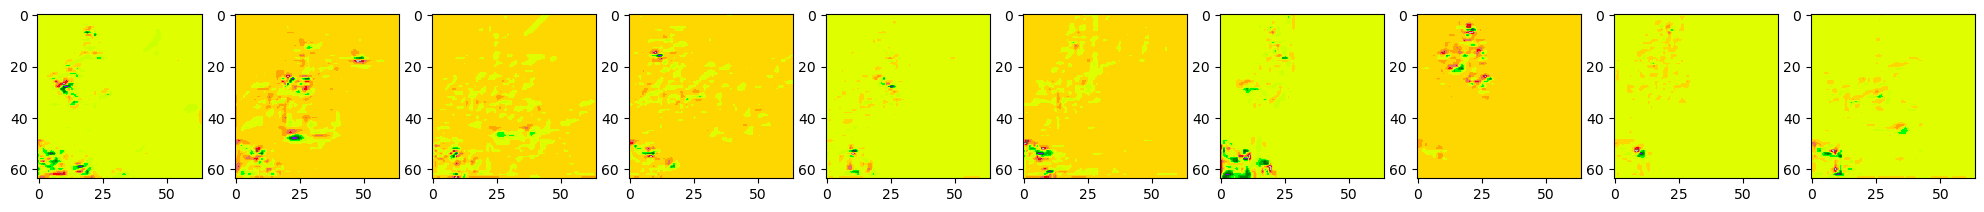

In [39]:
pics = 10

fig, axes = plt.subplots(1, pics, figsize=(5*5, 5))
for x in range(pics):
    #for n in range(pics, 0, -1):
    img = arr[x, :, :]
    axes[x].imshow(img, cmap= cmap_ndvi)
plt.show()

In [8]:
import xarray as xr
import os
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline

CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
path = os.path.join(config["SPI"]["ERA5"]["path"], "era5_total_precipitation_gc.nc")
ds = xr.open_dataset(path)
subsetting_pipeline(CONFIG_PATH, ds).isel(time=0)["total_precipitation"].plot()

In [ ]:
for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    print("single x shape: {}", x.shape)
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = engine.model(testx).transpose(1,3)
        print("single testx shape: {}", testx.shape)
        print("single prediction shape: {}", preds.shape)
        print("squeezed pred dims is: {}", preds.squeeze().shape)
        outputs.append(preds[:,0,:,:].squeeze())
        
yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]

In [5]:
for i in range(args.seq_length):
    pred = scaler.inverse_transform(yhat[:,:,i])
    real = realy[:,:,i]
    print(pred.shape)
    print(real.shape)
    print(pred[0].shape)
    base_path = os.path.join(args.output_dir, "predicted_data")
    ds = get_predicted_dataset(pred, dates, sub_cols)
    ds.to_netcdf(os.path.join(base_path, f"predicted_ndvi_{i}.nc"))

torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
